In [1]:
### SKRIPT BY THOMAS BRIAN WINKLER
### PART OF THE ARTICLE "ENEGETICS AND DYNAMICS OF A STABLE BLOCH POINT" by Winkler et al. (2023)
from magnum import *
from math import *
import numpy as np
import random
import os.path
import os
import time
import sys
import re
import matplotlib.pyplot as plt
%matplotlib inline

[   INFO] - Imported FFTW wisdom from file
[   INFO] - ----------------------------------------------------------------------
[   INFO] - MicMag 2.0rc0
[   INFO] - Copyright (C) 2012 - 2023 by the MicroMagnum team and the MicMag2 contributors.
[   INFO] - This program comes with ABSOLUTELY NO WARRANTY.
[   INFO] - This is free software, and you are welcome to redistribute it under
[   INFO] - certain conditions; see the file COPYING in the distribution package.
[   INFO] - ----------------------------------------------------------------------
[   INFO] - FFTW using 1 threads from now on
[   INFO] - CUDA GPU support: yes


In [3]:
def calc(nt, system, sample, write_nucleation):
    nar = 100
    naz1 = 30
    naz2 = 20
    a=0.4679*1e-09  # lattice constant of FeGe in m
    random.seed(0)
    t=(naz1+naz2)*a  #total thickness in [m]
    r=nar*a       #radius in [m]
    dia=2*r       #diameter in [m]  
    d = a*(naz1+naz2)/nt  #MM mesh size in [m] 
    nmmz = nt             # number of MM cells in z-direction
    nmm =int(round(dia/d)) # number of MM cells in x- and y-direction

    
    mu0 = 4*np.pi*1e-7   #mu0
    alpha = 0.28         #damping constant
    A =  8.78*1e-12         #Exchange constant in [J/m]
    Ms=0.384*1e6
    mu=Ms*a**3            #magnetic moment (for HB)
    J=2*A*a
    DISK = Material({
    'id': 'DISK',
    'Ms': Ms,
    'alpha': alpha,
    'A': A,
    'axis1': (0,0,1),
    'axis2': (0,1,0),
    'k_uniaxial': 0.0,
    'k_cubic': 0.0,
    'l':a,
    'mu':mu,
    'J':J})
    relax=0.5 #degree per nanosecond relax condition

    mesh = RectangularMesh((nmm, nmm, nmmz), (d, d, d))
    if sample == "rectangular":
        disk = Cuboid((0,0,0), (nmm*d,nmm*d,nmmz*d))
    if sample == "cylindrical":
        disk = Cylinder((nmm*d/2, nmm*d/2,0.0),(nmm*d/2, nmm*d/2,nmmz*d), nmm*d/2)
    world = World(mesh, Body("disk", DISK, disk))
    solver = create_solver(world, module_list =[StrayField, ExchangeField],
                           finescale = False,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
   
    folder = system+"/MM_"+sample+"/"
    folderwrite = system+"/MM_"+sample+"/nucleation_"+str(nt)+"/"

    if not os.path.isdir(folder): os.mkdir(folder)
    if not os.path.isdir(folderwrite): os.mkdir(folderwrite)

    solver.state.M = vortex.magnetizationFunction(nmm*d/2, nmm*d/2, 1,-1, core_radius=0.8e-9)
    #solver.state.Ms.fill(Ms)
    
    solver.state.M.normalize(1) # normalize spins to 1 for writing
    filenameinit = system+"_FMinit_nt_"+str(nt)+".omf"
    writeOMF(folder+filenameinit, solver.state.M)
    
    solver.state.M.normalize(1)
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2])
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    solver.state.M.normalize(Ms) # renormalize to M_s for energy
    eTFM, eSFM,eAFM, = solver.state.E_tot, solver.state.E_stray, solver.state.E_exch
    if write_nucleation:
        solver.addStepHandler(OOMMFStorage(folderwrite, "M"), condition.EveryNthSecond(2e-11))
    solver.state.M.normalize(Ms)
    solver.relax(relax)

    solver.state.M.normalize(1)
    filename_relaxed = system+"_relaxed_nt_"+str(nt)+".omf"
    writeOMF(folder+filename_relaxed, solver.state.M)    
    
    
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2])
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,0])
    plt.colorbar()
    plt.title("x-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,-1,2])
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()

    


[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch
[   INFO] -  - E_tot = E_stray + E_exch
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 40x40x10 cells
[   INFO] -   FFT size        : 80x80x20
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--40-40-10--80-80-20--2339-2339-2339.dat
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=79.0%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[   INFO] - Assign

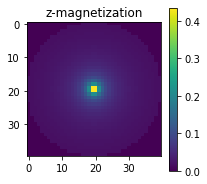

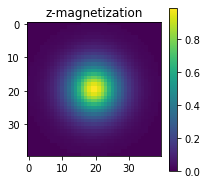

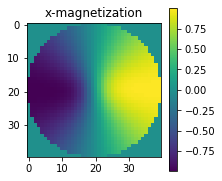

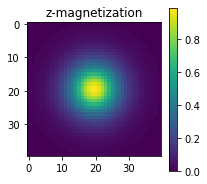

[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch
[   INFO] -  - E_tot = E_stray + E_exch
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 40x40x10 cells
[   INFO] -   FFT size        : 80x80x20
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--40-40-10--80-80-20--2339-2339-2339.dat
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=100.0%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[   INFO] - Assig

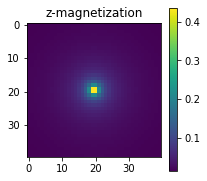

In [ ]:
system= "CV" #chossing configurations Bloch point (BP)

if os.path.isfile(system):
    os.mkdir(system)
write_nucleation = False
for nt in[10]: # thickness in units of FeGe lattice constant, in study [10, 20, 30, 40, 50]. 50 equals the atomistic lattice constant.
    for sample in ["cylindrical", "rectangular"]:
        calc(nt, system, sample, write_nucleation)
